In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from IPython.display import display
import itertools

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
def load_data(data_dir, target_size=(224, 224), batch_size=32, shuffle=True):
    datagen = ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle 
    )
    return data_generator

In [7]:
def create_model(input_shape, num_classes, learning_rate=0.001):
    base_model = tf.keras.applications.EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [8]:
def train_model(model, train_generator, val_generator, epochs=30):
    model_checkpoint = ModelCheckpoint("My_Efficient-B1.keras", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[model_checkpoint, reduce_lr])
    return history

In [9]:
def evaluate_model(model, test_generator):
    loss, acc = model.evaluate(test_generator, verbose=0)
    print("Test Accuracy:", np.round(acc * 100, 2))
    return loss, acc


In [10]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [11]:
def predict_random_image(model, test_generator, class_names):
    num_test_samples = len(test_generator.filenames)
    random_index = np.random.randint(0, num_test_samples)

    random_image_path = test_generator.filepaths[random_index]
    random_image = cv2.imread(random_image_path)
    random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
    random_image = cv2.resize(random_image, (224, 224))
    random_image = random_image.astype('float32') / 255.0

    plt.imshow(random_image)
    plt.axis('off')
    plt.title("Random Image to Predict")
    plt.show()

    true_label = test_generator.filenames[random_index]
    print("Actual label:", true_label)

    prediction_prob = model.predict(np.expand_dims(random_image, axis=0))
    predicted_label_index = np.argmax(prediction_prob)
    
    class_names = list(class_names)  
    predicted_label = class_names[predicted_label_index]
    print("Predicted label:", predicted_label)

In [12]:
train_generator = load_data("/kaggle/input/my-rice-splitted-ds/Spliited_Ds/train")
val_generator = load_data("/kaggle/input/my-rice-splitted-ds/Spliited_Ds/val")
test_generator = load_data("/kaggle/input/my-rice-splitted-ds/Spliited_Ds/test", shuffle=False)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/my-rice-splitted-ds/Spliited_Ds/train'

In [ ]:
model = create_model((224, 224, 3), num_classes=len(train_generator.class_indices), learning_rate=0.001)
history = train_model(model, train_generator, val_generator)

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6902 - loss: 0.7474
Epoch 1: val_accuracy improved from -inf to 0.23892, saving model to My_Efficient-B1.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 781s 7s/step - accuracy: 0.6910 - loss: 0.7457 - val_accuracy: 0.2389 - val_loss: 2.2420 - learning_rate: 0.0010
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8658 - loss: 0.3795
Epoch 2: val_accuracy improved from 0.23892 to 0.36453, saving model to My_Efficient-B1.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 745s 7s/step - accuracy: 0.8658 - loss: 0.3794 - val_accuracy: 0.3645 - val_loss: 2.8710 - learning_rate: 0.0010
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8988 - loss: 0.3155
Epoch 3: val_accuracy did not improve from 0.36453
102/102 ━━━━━━━━━━━━━━━━━━━━ 729s 7s/step - accuracy: 0.8988 - loss: 0.3154 - val_accuracy: 0.2660 - val_loss: 1.9653 - learning_rate: 0.0010
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9226 - loss: 0.2128
Epoch 4: 

In [ ]:
model.save("/kaggle/working/My_Efficient-B1.h5")

In [ ]:
loss, acc = evaluate_model(model, test_generator)

Test Accuracy: 93.43


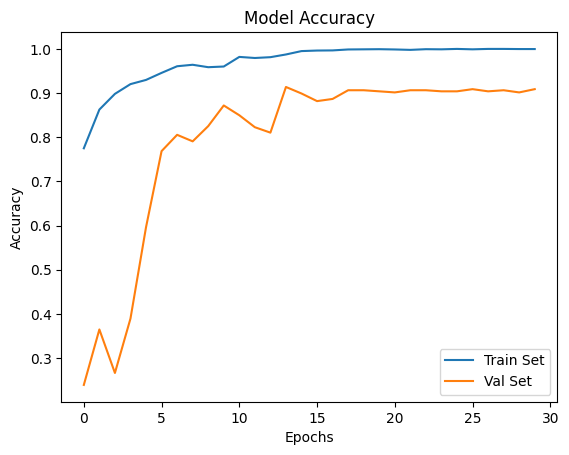

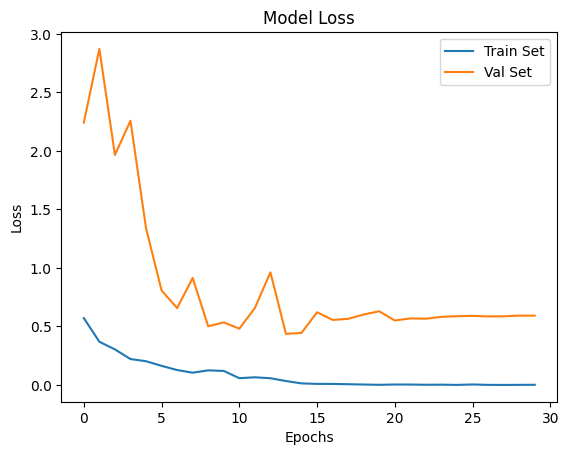

In [ ]:
plt.plot(history.history['accuracy'], label='Train Set')
plt.plot(history.history['val_accuracy'], label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Set')
plt.plot(history.history['val_loss'], label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

In [ ]:
test_pred_prob = model.predict(test_generator)
test_pred_labels = np.argmax(test_pred_prob, axis=1)
test_true_labels = test_generator.classes
class_names = list(train_generator.class_indices.keys())
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
                precision    recall  f1-score   support

Rice_BrownSpot       0.89      0.89      0.89        62
  Rice_Healthy       0.92      0.97      0.94       150
Rice_LeafBlast       0.92      0.85      0.88        99
Rice_NeckBlast       1.00      1.00      1.00       100

      accuracy                           0.93       411
     macro avg       0.93      0.93      0.93       411
  weighted avg       0.93      0.93      0.93       411



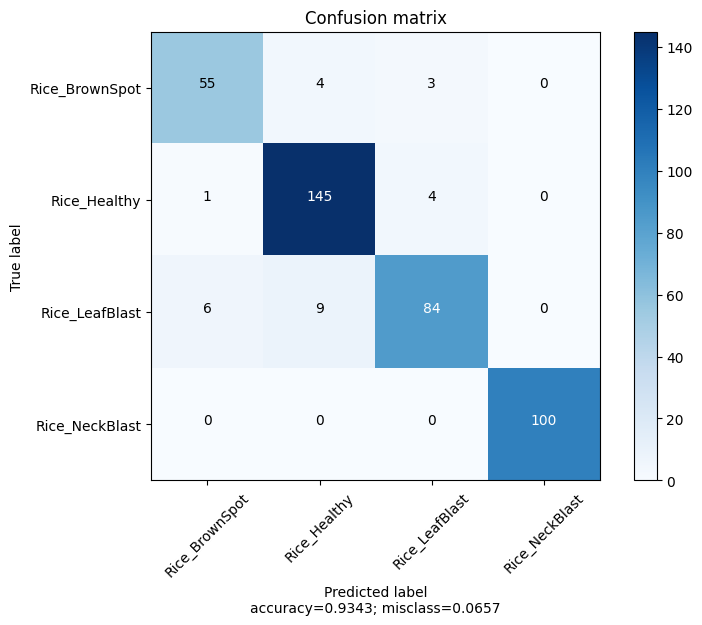

In [ ]:
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
plot_confusion_matrix(conf_matrix, target_names=class_names)

In [ ]:
precision = precision_score(test_true_labels, test_pred_labels, average='weighted')
recall = recall_score(test_true_labels, test_pred_labels, average='weighted')
f1_score = f1_score(test_true_labels, test_pred_labels, average='weighted')
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print evaluation measures
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Precision: 0.9344108107851987
Recall: 0.9343065693430657
F1 Score: 0.9337484387810935
Sensitivity: 0.9931506849315068
Specificity: 0.9322033898305084


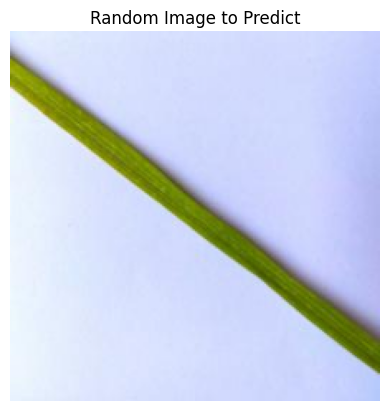

Actual label: Rice_Healthy/IMG_20190419_112033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted label: Rice_Healthy


In [ ]:
predict_random_image(model, test_generator, train_generator.class_indices.keys())

In [ ]:
cross_test_generator = load_data("/kaggle/input/validation-ds/test", shuffle=False)

Found 2103 images belonging to 4 classes.


In [ ]:
print("Accuracy on Cross Dataset:")
cross_loss, cross_acc = evaluate_model(model, cross_test_generator)

Accuracy on Cross Dataset:


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 92.15


In [ ]:
cross_pred_prob = model.predict(cross_test_generator)
cross_pred_labels = np.argmax(cross_pred_prob, axis=1)
cross_true_labels = cross_test_generator.classes
cross_class_names = list(cross_test_generator.class_indices.keys())
print(classification_report(cross_true_labels, cross_pred_labels, target_names=cross_class_names))

66/66 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step
              precision    recall  f1-score   support

   BrownSpot       0.95      0.93      0.94       523
     Healthy       0.94      0.83      0.88       525
   LeafBlast       0.82      0.93      0.87       524
   NeckBlast       1.00      1.00      1.00       531

    accuracy                           0.92      2103
   macro avg       0.93      0.92      0.92      2103
weighted avg       0.93      0.92      0.92      2103



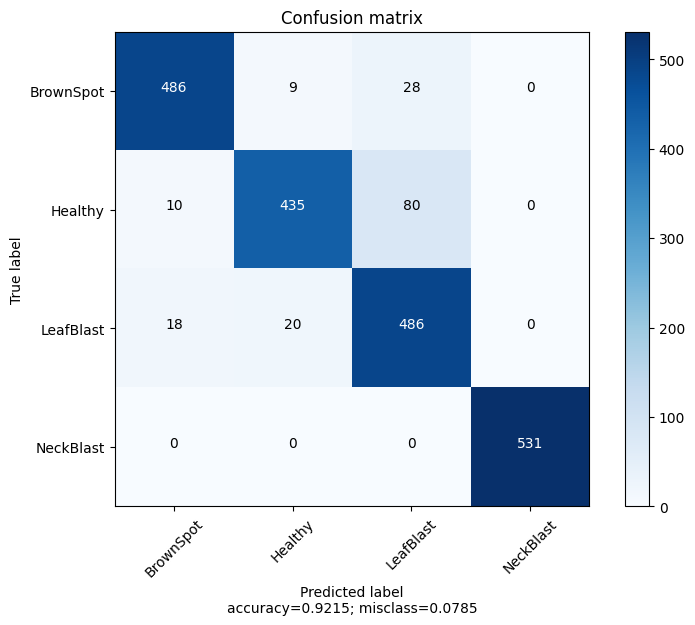

In [ ]:
cross_conf_matrix = confusion_matrix(cross_true_labels, cross_pred_labels)
plot_confusion_matrix(cross_conf_matrix, target_names=cross_class_names)

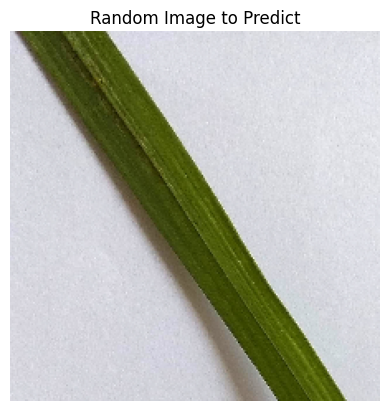

Actual label: Healthy/IMG_20190424_125838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted label: Healthy


In [ ]:
# Predict on a random image from cross-validation dataset
predict_random_image(model, cross_test_generator, cross_test_generator.class_indices.keys())